In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd, numpy as np
from rasterio.mask import mask

from types_data import settlement

In [20]:
shp_path = "../Data/gjson/adm_3.geojson"
settlem_path = (
    "../Data/Raster/settlement/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.tif"
)

shp_data = gpd.read_file(shp_path).sort_values("area", ascending = False)

shp_data.head(2)

,id,fnid,name,unit_type_code,parent_id,start_date,end_date,country_code,fewsnet_region,geographic_group,...,layer_id,layer_name,geographicunitsetversion_name,zone_type,urban_rural,start_month,area,attributes,fid,geometry
112,222908,ET2023A3020207,Afdera,admin3,222703,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,12805.0,"{'FNID': 'ET2023A3020207', 'ADMIN0': 'Ethiopia...",112,"MULTIPOLYGON (((41.46327 13.50482, 41.45752 13..."
761,223557,ET2023A3050503,Shilabo,admin3,222748,2023-10-01,None,ET,East Africa,Eastern Africa,...,4697,ET_Admin3_2023,Ethiopia FEWS NET Admin Boundaries: From 10/01...,None,None,None,12163.0,"{'FNID': 'ET2023A3050503', 'ADMIN0': 'Ethiopia...",761,"POLYGON ((45.25200 6.39700, 45.25369 6.39416, ..."


# Sample


In [21]:
def crop_messy_raster(
    raster_path: str,
    gdf: gpd.GeoDataFrame,
    out_raster_file: str = None,
):

    with rio.open(raster_path) as raster:
        crs_raster = raster.crs.to_dict()
        gdf_raster_proj = gdf.to_crs(crs_raster)
        raster_cropped, transformation = mask(
            raster, gdf_raster_proj.geometry, crop=True
        )

        meta = raster.meta.copy()
        meta.update(
            {
                "driver": "GTiff",
                "height": raster_cropped.shape[1],
                "width": raster_cropped.shape[2],
                "transform": transformation,
                "crs": crs_raster,
            }
        )

    if out_raster_file is not None:
        with rio.open(out_raster_file, "w", **meta) as dest:
            dest.write(raster_cropped)
    return transformation, raster_cropped


def raster_to_data(transformation, raster_cropped) -> pd.DataFrame:
    values = raster_cropped.flatten()
    rows, cols = np.indices(raster_cropped.shape[-2:])
    x, y = rio.transform.xy(transformation, rows.flatten(), cols.flatten())

    data = {"x": x, "y": y, "z": values}
    df = pd.DataFrame(data)
    return df


def settlement_na(df, with_na: bool = False) -> pd.DataFrame:
    if with_na:
        # df = df.query('z > 0')
        df.loc[(df["z"] <= 0) | (df["z"] > 100), "z"] = 0
        return df
    # without_ NAS
    df = df.query("z > 0 & z < 100")
    return df


def summary_settlement(
    df: pd.DataFrame, names_settlement=["Settlement", "Count", "Percent %"]
) -> pd.DataFrame:

    data_settle = df.value_counts("z").reset_index().sort_values("z")

    data_settle["percent"] = data_settle["count"] / sum(data_settle["count"]) * 100
    data_settle = data_settle.round(2)
    data_settle["percent"] = data_settle["percent"].astype(str) + " %"
    data_settle.columns = names_settlement
    data_settle[names_settlement[0]] = data_settle[names_settlement[0]].replace(
        settlement.labels
    )

    return data_settle

In [22]:
sample = shp_data.iloc[0:1]
trasformed, raster_c = crop_messy_raster(settlem_path, sample, "../output/trash/test.tiff")
df = raster_to_data(trasformed, raster_c)

df1 = settlement_na(df)
summary_settlement(df1)

,Settlement,Count,Percent %
0,"1: MSZ, open spaces, low vegetation surfaces N...",19309,54.99 %
3,"2: MSZ, open spaces, medium vegetation surface...",56,0.16 %
4,"3: MSZ, open spaces, high vegetation surfaces ...",1,0.0 %
2,"5: MSZ, open spaces, road surfaces",158,0.45 %
1,"11: MSZ, built spaces, residential, building h...",15591,44.4 %


In [23]:
df2 = settlement_na(df, True)
summary_settlement(df2)

,Settlement,Count,Percent %
0,0: NODATA,208989058,99.98 %
1,"1: MSZ, open spaces, low vegetation surfaces N...",19309,0.01 %
4,"2: MSZ, open spaces, medium vegetation surface...",56,0.0 %
5,"3: MSZ, open spaces, high vegetation surfaces ...",1,0.0 %
3,"5: MSZ, open spaces, road surfaces",158,0.0 %
2,"11: MSZ, built spaces, residential, building h...",15591,0.01 %


In [15]:
# sample.plot()

In [24]:
from matplotlib.colors import LinearSegmentedColormap
def plot_raster(
    raster_name: str
    , transformation_data
    # , original_shp_path = None
    # , name_plot = "settlement_islamabad"
    , original_shp = None
    , map_color_hex=(
        "#d3d4de",
        "#b2edc2", "#0eb33b", 
        "#102985", 
        "#cfb38f", 
        "#c579d1", "#581363",
        "#c1f4f5",
        )
    , break_points =  [
        0, 0.2,
        0.20, 
        0.3, 
        0.39, 0.66,
        0.70, 1
    ]
):

    # if original_shp:
    gdf = original_shp
    # else:
    #     gdf = gpd.read_file(original_shp_path)
    
    map_color = [(bp, col) for bp, col in zip(break_points, map_color_hex)]
    # map_color = [()
        
    #     (0.0, c0), (0.1, c1), (0.5, c2), (1.0, c3)]
    cmap_vals = sorted(map_color, key=lambda x: x[0])  
    # print(map_color)
    cmap = LinearSegmentedColormap.from_list("custom", cmap_vals)

    with rio.open(raster_name) as raster:
        data = raster.read(1)
        nodata_value = raster.nodata
        crs = raster.crs.to_dict()
        gdf_raster = gdf.to_crs(crs)
        data = np.where(data == nodata_value, np.nan, data)
        height, width = data.shape
        inv_transform = transformation_data
        xs = np.arange(0, width) * inv_transform.a + inv_transform.xoff
        ys = np.arange(0, height) * inv_transform.e + inv_transform.yoff
        plt.figure(figsize=(4, 4))
        plt.imshow(data, extent=[xs[0], xs[-1], ys[-1], ys[0]], cmap=cmap)
        # plt.title("Islamabad - Settlement")

        # ################
        # replace = 
        labels = settlement.labels
        legend_labels = list(labels.values())
        legend_colors = [plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(labels.keys()), vmax=max(labels.keys()))).to_rgba(key) for key in labels.keys()]

        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)], loc='center left', bbox_to_anchor=(1, 0.5))
        # ########### 

        
        gdf_raster.plot(ax=plt.gca(), edgecolor='red', facecolor='none')


        plt.show()

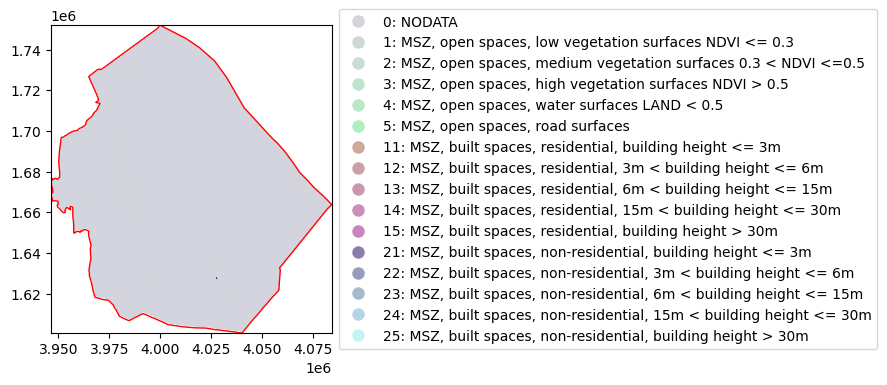

In [25]:
plot_raster('../output/trash/test.tiff', trasformed, original_shp= sample)

# Loop
